In [7]:
import os

import pandas as pd
import numpy as np
import datetime as dt
import glob

import seaborn as sns
import matplotlib.pyplot as plt

import src.visualization as vs
import src.json_cleaning as jc


In [10]:
#import all csv-files and concatenate them to on raw kickstarter file
df_list = []

for filename in glob.glob('data/raw/*.csv'):
    df_import = pd.read_csv(filename)
    df_list.append(df_import)

data = pd.concat(df_list, ignore_index=True)
data.to_csv('data/raw/kickstarter.csv', index = False)

In [11]:
data = pd.read_csv('data/raw/kickstarter.csv')

def drop_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicate rows, and rows that are duplicated and rows that only differ in usd_type"""

    df = df.query('~(id.duplicated() & usd_type == "domestic")')
    df = df.drop_duplicates('id', keep='first')
    return df

data = drop_duplicates(data)

In [12]:
# convert goal with static_usd_rate, drop both afterwards and keep converted goal
def goal_convert(df):
    df['converted_goal'] = (df['goal'].mul(df['static_usd_rate'])).round(2)
    df['usd_pledged'] = df['usd_pledged'].round(2)
    df.drop(['goal','static_usd_rate'], axis =1, inplace = True)
    return df

data = goal_convert(data)

data.shape

(182264, 36)

In [13]:
# 'blurb' and 'name' to len()
def string_length(df):
    df['len_blurb'] = df['blurb'].str.split().str.len()
    df['len_name'] = df['name'].str.split().str.len()
    df.drop(['blurb', 'name'], axis = 1, inplace = True)
    return df

data = string_length(data)

data.shape

(182264, 36)

In [14]:
# created and launch time windows
date_columns = ['created_at','deadline','launched_at']

# for column in date_columns:
#     data[column] = data[column].apply(dt.datetime.fromtimestamp)

launch_to_deadline = (data['deadline'] - data['launched_at'])
creation_to_launch = (data['launched_at'] - data['created_at'])

data['launch_to_deadline'] = launch_to_deadline
data['creation_to_launch'] = creation_to_launch

data['month'] = pd.to_datetime(data['launched_at'], unit='s').dt.month_name()
data['weekday'] = pd.to_datetime(data['launched_at'], unit='s').dt.day_name()
data['day_hour'] = pd.to_datetime(data['launched_at'], unit='s').dt.hour

data.drop(date_columns, axis=1, inplace=True)

# launch_to_deadline_days = launch_to_deadline.dt.days
# launch_to_deadline_minutes = launch_to_deadline.dt.seconds // 60

# creation_to_launch_days = creation_to_launch.dt.days
# creation_to_launch_minutes = creation_to_launch.dt.seconds // 60

# time_df = pd.concat([launch_to_deadline_days, launch_to_deadline_minutes,
#                      creation_to_launch_days, creation_to_launch_minutes],
#                     axis=1,
#                     keys = ['launch_to_deadline_days', 'launch_to_deadline_minutes',
#                             'creation_to_launch_days', 'creation_to_launch_minutes'])

In [15]:
# convert category vars to categories
col = ['category']
data = jc.json_cleaning(data, col)

#Get parent category from category_slug
data['parent_category'] = data['category_slug'].apply(lambda x: x.split('/')[0])
data.head()

,backers_count,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,disable_communication,friends,...,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name,category_slug,parent_category
0,315,28645,US,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,USD,False,NaN,...,2.0,3,4316400,6764170,January,Wednesday,6,Footwear,fashion/footwear,fashion
1,47,1950,US,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,False,NaN,...,22.0,4,2592000,700366,August,Thursday,17,Playing Cards,games/playing cards,games
2,271,22404,US,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,False,NaN,...,15.0,7,2592000,19433862,May,Monday,5,Rock,music/rock,music
3,3,165,GB,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,USD,False,NaN,...,23.0,8,5180400,465105,January,Thursday,18,Playing Cards,games/playing cards,games
4,3,2820,US,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,USD,False,NaN,...,24.0,7,2592000,354456,December,Monday,20,Nonfiction,publishing/nonfiction,publishing


In [16]:
# drop everything that isn't successful or failed
data = data.query('state == "successful" | state == "failed" ')
data.state = data.state.apply(lambda x: 0 if 'failed' in x else 1)

In [20]:
drop_these = [
    'converted_pledged_amount',
    'currency',
    'currency_symbol',
    'currency_trailing_code',
    'current_currency',
    'disable_communication',
    'friends',
    'fx_rate',
    'id',
    'is_backing',
    'is_starrable',
    'is_starred',
    'permissions',
    'pledged',
    'slug',
    'source_url',
    'spotlight',
    'state_changed_at',
    'urls',
    'category_slug'
    ]

drop_these_too = [
    'creator',
    'location',
    'photo',
    'profile',
]

data.drop(drop_these, axis=1, inplace=True)
data.drop(drop_these_too, axis=1, inplace=True)

<AxesSubplot:xlabel='launch_to_deadline', ylabel='Count'>

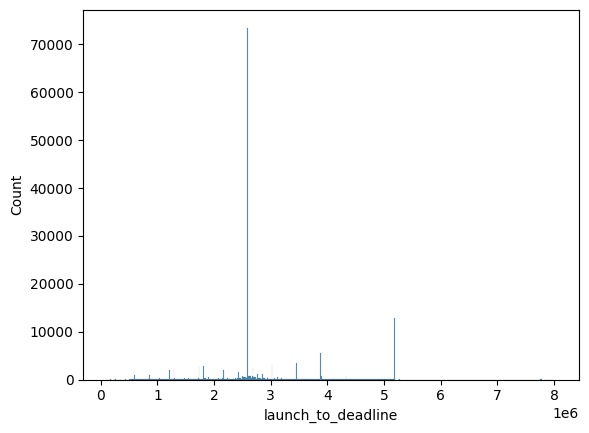

In [32]:
vs.nice_summary(data)

# sns.histplot(data=time_df, x='launch_to_deadline')

# it looks like projects can be created but not immediately launched
# once a project is launched there is a maximum funding time of 93 days (3 months)

# when do people launch their projects?
# when are they more likely to postpone the launch?